# Compare Different SAM2 Checkpoints

In [1]:
import os
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import matplotlib.pyplot as plt
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import os
from PIL import Image
import numpy as np

        


In [2]:
# use bfloat16 for the entire notebook
# from Meta notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

checkpoint = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/models/Train20_b+_like_sa1b/checkpoints/checkpoint.pt"
model_cfg = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/sam2/sam2/configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
finetuned_generator = SAM2AutomaticMaskGenerator(
    sam2,
    points_per_side=80
)
checkpoint_base = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/sam2/checkpoints/sam2.1_hiera_base_plus.pt"
sam2_base = build_sam2(model_cfg, checkpoint_base, device="cuda")
generator = SAM2AutomaticMaskGenerator(
    sam2_base,
    points_per_side=80
)

checkpoint_large = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg_large = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/sam2/sam2/configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_large = build_sam2(model_cfg_large, checkpoint_large, device="cuda")
generator_large = SAM2AutomaticMaskGenerator(
    sam2_large,
    points_per_side=80
)

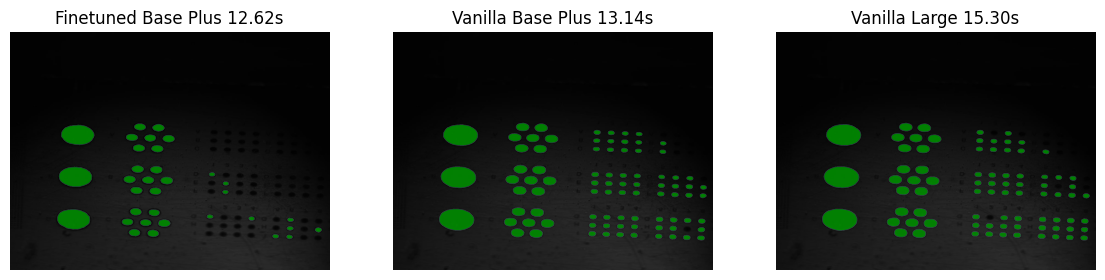

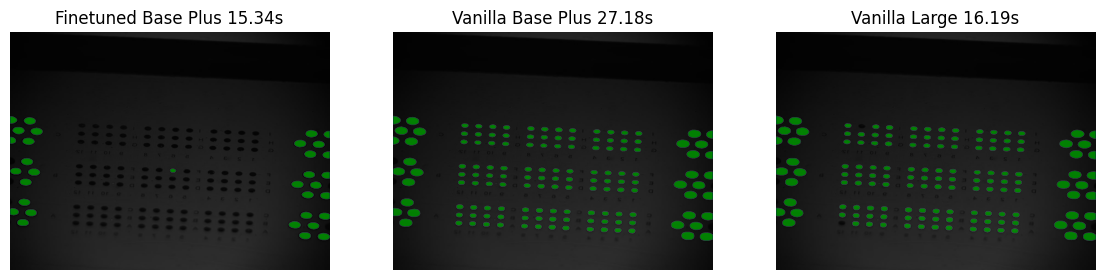

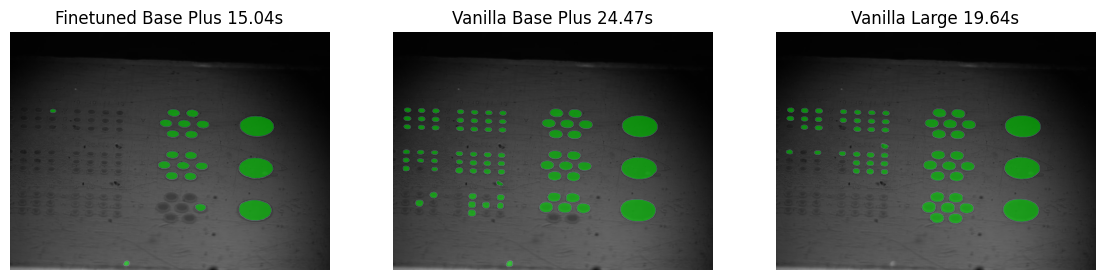

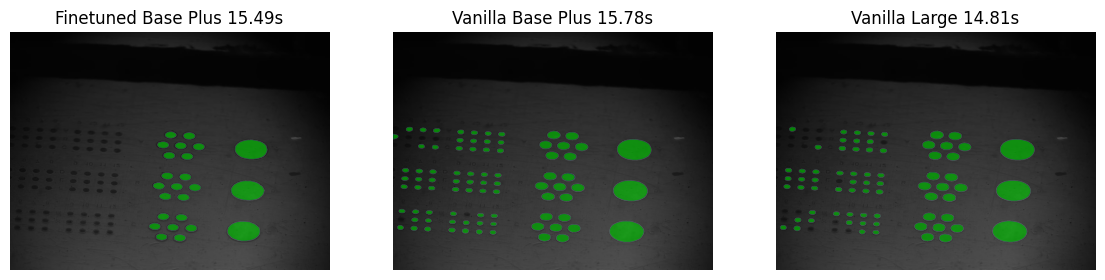

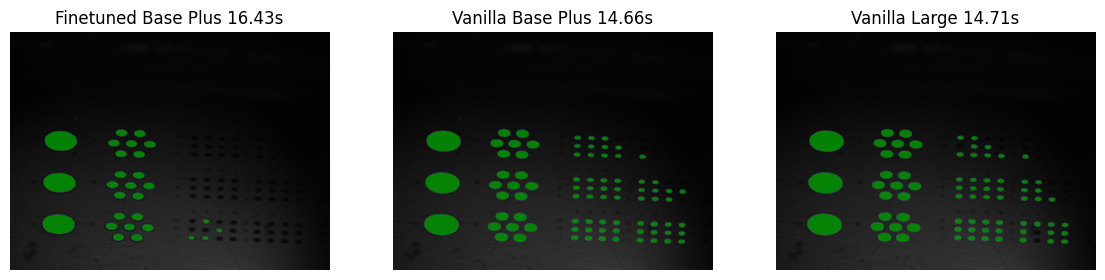

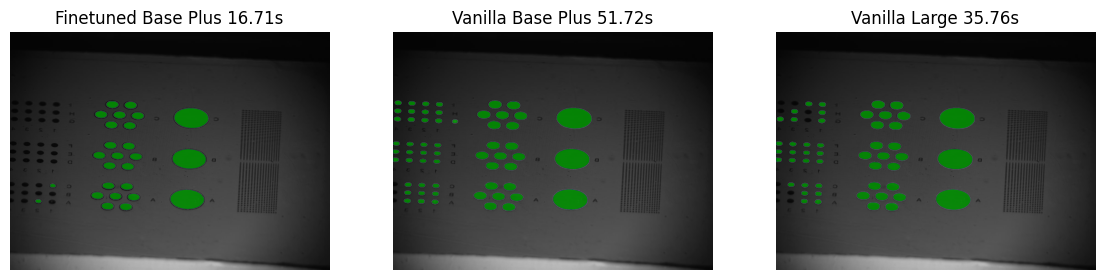

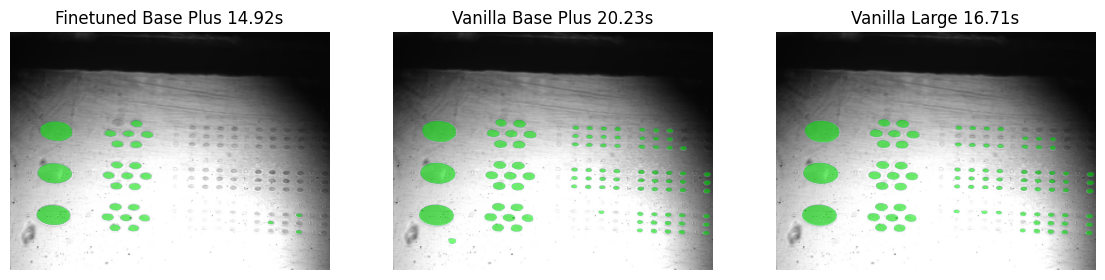

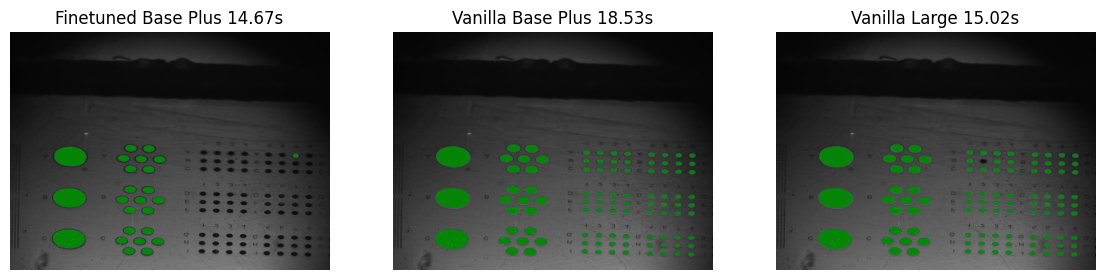

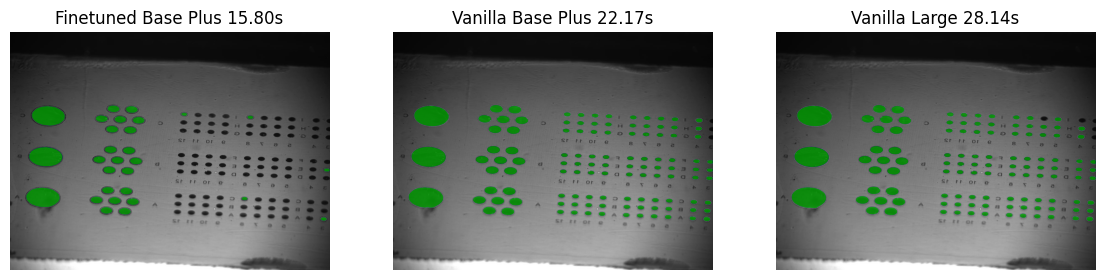

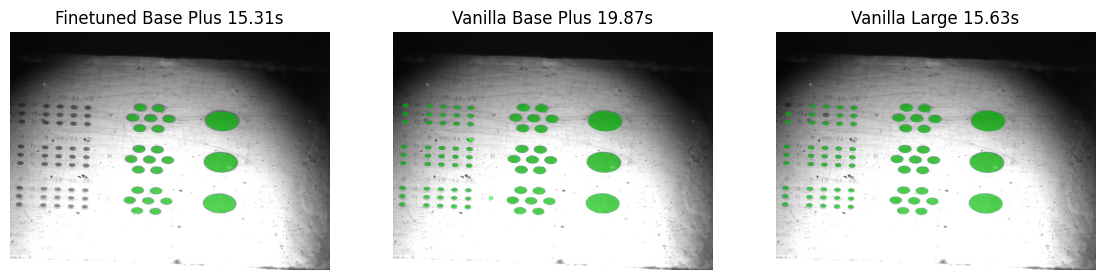

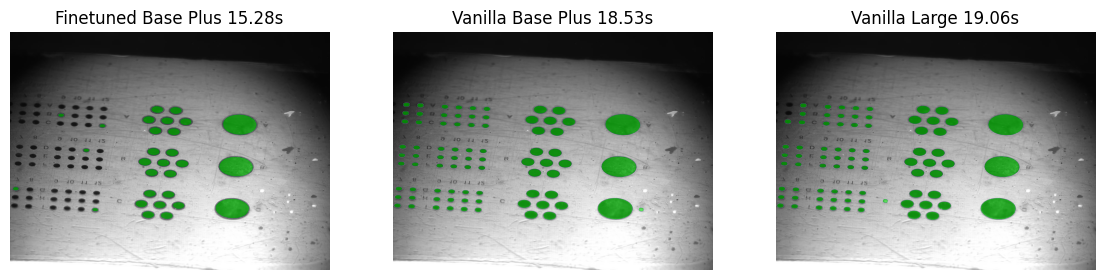

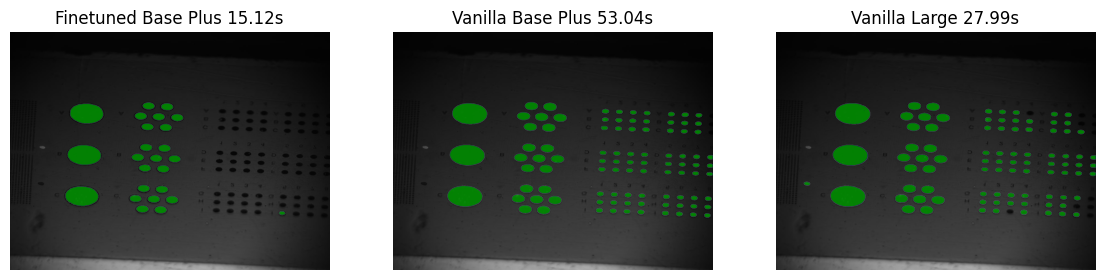

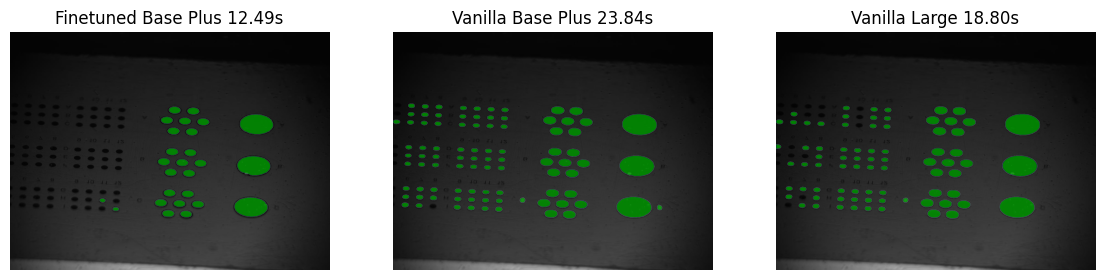

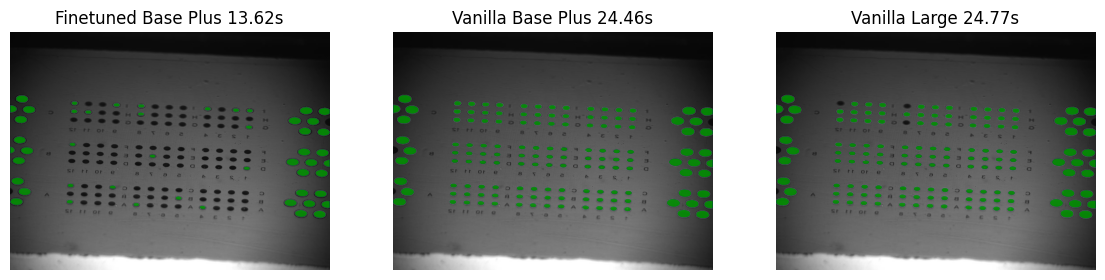

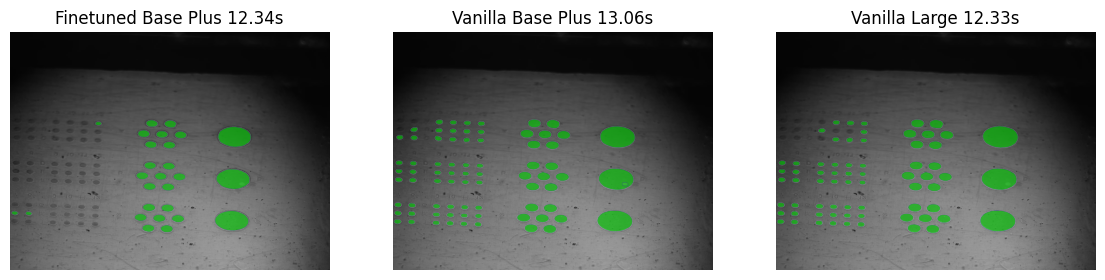

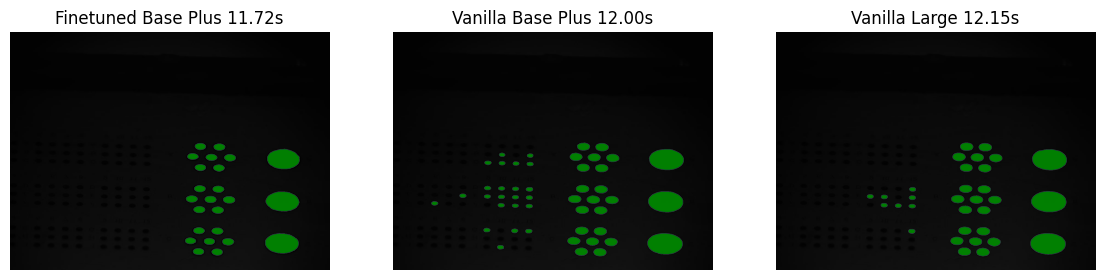

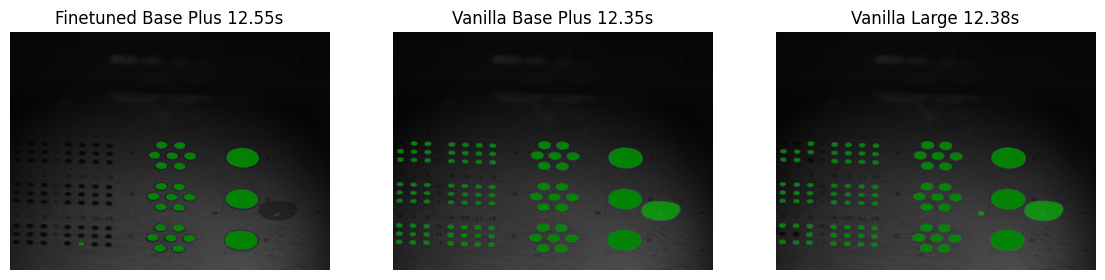

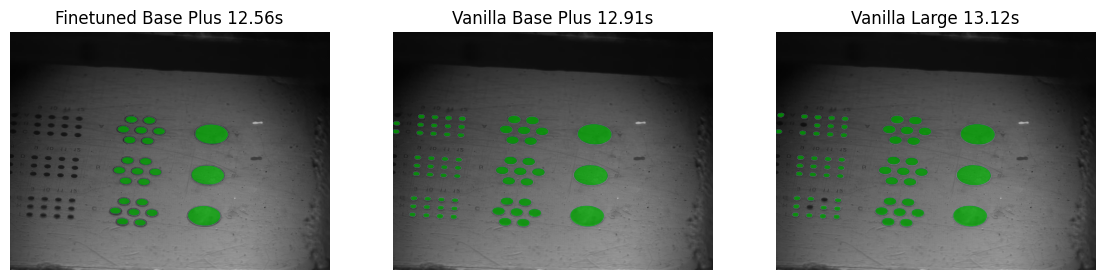

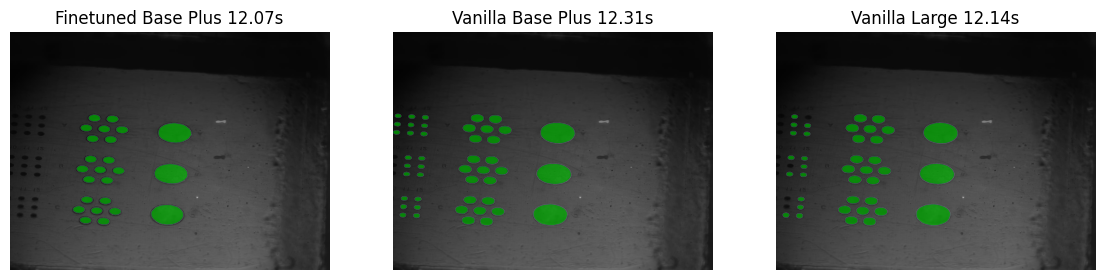

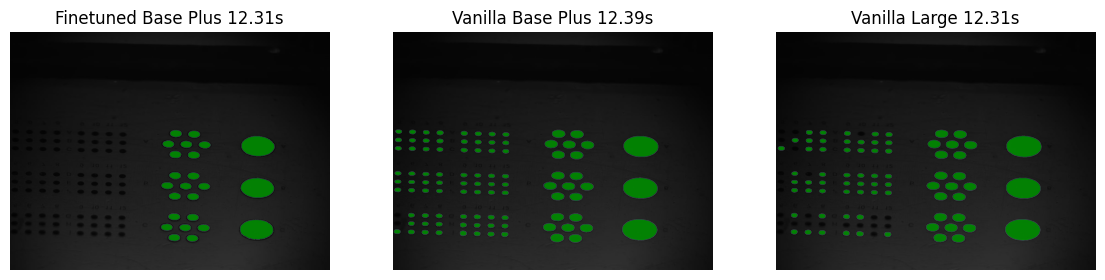

Finetuned Base Plus average time: 14.12s
Vanilla Base Plus average time: 21.13s
Vanilla Large average time: 17.85s


In [3]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import time

# Mask visualization for AMG masks
def show_anns(anns, ax=None):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) 
    if ax is None:
        ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.array([0.0, 1.0, 0.0, 0.5])
        img[m] = color_mask 
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

# Function to calculate circularity of a contour
def compute_circularity(mask):
    mask_uint8 = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0  # No valid contour found

    contour = max(contours, key=cv2.contourArea)  # Get the largest contour
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0:  # Avoid division by zero
        return 0

    circularity = (4 * np.pi * area) / (perimeter ** 2)
    return circularity


folder_path = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Train20/Raw"
all_files = os.listdir(folder_path)

f_avg = []
b_avg = []
l_avg = []
count = 0

for name in all_files:
    if name.endswith(".jpg"):
        count += 1
        img = np.array(Image.open(os.path.join(folder_path, name)).convert("RGB"))
        
        time_finetuned = time.time()
        finetuned_masks = finetuned_generator.generate(img)
        time_finetuned = time.time() - time_finetuned
        f_avg.append(time_finetuned)

        time_base = time.time()
        masks = generator.generate(img)
        time_base = time.time() - time_base
        b_avg.append(time_base)
        
        time_large = time.time()
        masks_large = generator_large.generate(img)
        time_large = time.time() - time_large
        l_avg.append(time_large)
        
        height, width = img.shape[:2]
        area = height * width

        masks = [mask for mask in masks if 0.00025 < mask['area'] / area < 0.03]
        masks = [mask for mask in masks if compute_circularity(mask['segmentation']) >= 0.75]
        finetuned_masks = [mask for mask in finetuned_masks if 0.00025 < mask['area'] / area < 0.03]
        finetuned_masks = [mask for mask in finetuned_masks if compute_circularity(mask['segmentation']) >= 0.75]
        masks_large = [mask for mask in masks_large if 0.00025 < mask['area'] / area < 0.03]
        masks_large = [mask for mask in masks_large if compute_circularity(mask['segmentation']) >= 0.75]
            
        fig, axes = plt.subplots(1, 3, figsize=(14, 7))
        
        # Display original image
        axes[0].imshow(img)
        show_anns(finetuned_masks, axes[0])
        axes[0].set_title(f'Finetuned Base Plus {time_finetuned:.2f}s')
        
        # Display image with all masks
        axes[1].imshow(img)
        show_anns(masks, axes[1])
        axes[1].set_title(f'Vanilla Base Plus {time_base:.2f}s')
        
        # Display image with all masks
        axes[2].imshow(img)
        show_anns(masks_large, axes[2])
        axes[2].set_title(f'Vanilla Large {time_large:.2f}s')
        
        axes[0].axis('off')
        axes[1].axis('off')
        axes[2].axis('off')

        plt.show()
        
f_avg = np.sum(f_avg) / count
b_avg = np.sum(b_avg) / count
l_avg = np.sum(l_avg) / count
print(f"Finetuned Base Plus average time: {f_avg:.2f}s")
print(f"Vanilla Base Plus average time: {b_avg:.2f}s")
print(f"Vanilla Large average time: {l_avg:.2f}s")

In [4]:
from PIL import Image
from ipywidgets import interact, IntSlider 
import numpy as np

def plot_image_with_points(image_path, n):
    # Load the image
    img = Image.open(image_path)
    img_array = np.array(img)

    # Get image dimensions
    height, width = img_array.shape[:2]

    # Compute point positions
    x = np.linspace(0, width - 1, n)
    y = np.linspace(0, height - 1, n)
    xx, yy = np.meshgrid(x, y)

    # Plot image and points
    plt.figure(figsize=(8, 8))
    plt.imshow(img_array)
    plt.scatter(xx, yy, color='red', s=5)  # adjust size/color as needed
    plt.axis('off')
    plt.title(f'{n}×{n} Points Overlay')
    plt.show()

image_path = "C:\\Users\\Micha\\Desktop\\BachelorProject\\AI-Powered-Biosensing\\data\\Train20\\JPEGImages\\00\\00.jpg"
interact(lambda n: plot_image_with_points(image_path, n),
         n=IntSlider(min=8, max=128, step=8, value=5, description='Grid Points per Side'))


interactive(children=(IntSlider(value=8, description='Grid Points per Side', max=128, min=8, step=8), Output()…

<function __main__.<lambda>(n)>

Add metric to compare models quantitatively: IoU against ground truth masks + number of detected wells against ground truth masks + time per mask